# Analyzing the Gender Wage Gap Over Time
# Brian Mann

In [164]:
# imported libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import skew
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import lognorm, kstest
from scipy.stats import kendalltau

In [3]:
# read the data into a data frame
wages = pd.read_csv("wages_by_education.csv")
wages.head()

,year,less_than_hs,high_school,some_college,bachelors_degree,advanced_degree,men_less_than_hs,men_high_school,men_some_college,men_bachelors_degree,...,black_women_less_than_hs,black_women_high_school,black_women_some_college,black_women_bachelors_degree,black_women_advanced_degree,hispanic_women_less_than_hs,hispanic_women_high_school,hispanic_women_some_college,hispanic_women_bachelors_degree,hispanic_women_advanced_degree
0,1973,18.06,22.22,24.08,32.80,38.16,21.18,26.90,27.67,37.69,...,12.02,15.79,18.11,28.35,41.81,12.92,16.46,20.22,22.23,25.10
1,1974,17.68,21.60,23.32,31.69,38.37,20.63,26.15,26.79,36.62,...,12.31,15.55,18.19,27.80,33.86,13.24,16.29,18.17,21.70,26.74
2,1975,17.30,21.55,23.30,31.45,38.41,20.00,26.02,26.93,36.21,...,12.48,15.88,18.11,27.93,33.03,12.87,16.04,17.04,18.85,23.63
3,1976,17.52,21.76,23.49,31.46,37.50,20.36,26.14,27.10,36.42,...,12.75,16.40,19.11,26.10,34.92,13.79,17.29,17.40,20.29,20.93
4,1977,17.59,21.50,22.97,31.07,37.36,20.43,25.97,26.70,36.09,...,12.80,16.30,18.87,25.83,37.10,12.66,17.22,17.12,21.49,30.31


In [10]:
# variables used, separated by year, overall, men and women
years = wages.iloc[:,0]
overall = wages.iloc[:,1:6]
men = wages.iloc[:,6:11]
women = wages.iloc[:,11:16]

In [26]:
# this function generates a histogram for each of the columns in the given data frame
def make_hist(df, name):
    # set up the subplots and colors
    fig, ax = plt.subplots()
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    # the the binwidth to $1 and make the histogram for each column
    for i, col in enumerate(df.columns):
        ax.hist(df[col], bins=range(int(min(df[col])), int(max(df[col])) + 1, 1), 
                color=colors[i], alpha=0.5, label=col)
    # make the axes limits the same for each plot     
    plt.xlim(10, 60)
    plt.ylim(0, 30)
    plt.xlabel('Wage (\$/hour)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {name} Data')
    plt.legend()
    plt.show()

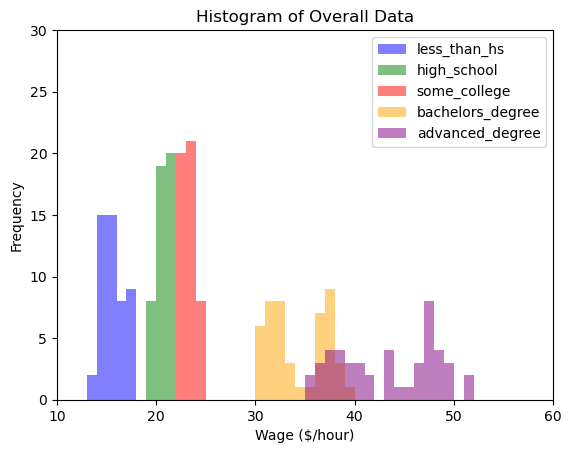

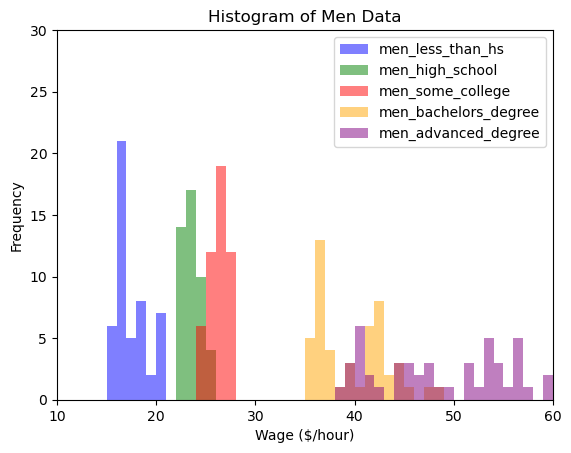

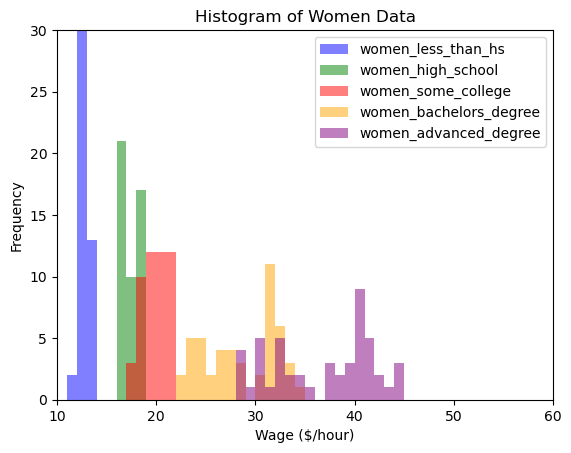

In [27]:
# use this  list of dfs and names to generate each of the histogram plots
df_and_names = [(overall, "Overall"),(men, "Men"),(women, "Women")]
for x in df_and_names:
    df, name = x
    make_hist(df, name)

In [32]:
# gather a list of each of the data frames
dfs = [overall, men, women]

In [38]:
# this function takes in a data frame and gives the mean, median, range, and skew for each column
def make_summary_stats(df):
    means = df.mean()
    medians = df.median()
    ranges = df.max() - df.min()
    skews = df.apply(skew)
    summary_stats = pd.DataFrame({
    'Mean': means,
    'Median': medians,
    'Range': ranges,
    'Skew': skews
    })
    
    print(summary_stats)

In [40]:
for df in dfs:
    make_summary_stats(df)

                     Mean  Median  Range      Skew
less_than_hs      15.7026  15.340   4.11  0.520736
high_school       20.8766  20.855   3.08  0.134490
some_college      23.2192  23.185   3.40  0.646484
bachelors_degree  34.7686  34.205  11.61  0.319095
advanced_degree   43.8990  44.085  18.42  0.018634
                         Mean  Median  Range      Skew
men_less_than_hs      17.5652  16.905   5.79  0.674019
men_high_school       23.8326  23.695   4.79  0.697004
men_some_college      26.3338  26.365   3.77  0.004734
men_bachelors_degree  39.9884  39.485  13.85  0.564821
men_advanced_degree   49.4302  48.940  24.80  0.164481
                           Mean  Median  Range      Skew
women_less_than_hs      12.8514  12.810   2.65  0.932343
women_high_school       17.5716  17.370   2.91  0.348900
women_some_college      19.9432  19.985   4.44 -0.121558
women_bachelors_degree  28.9264  29.425  12.47 -0.145332
women_advanced_degree   36.9752  38.345  17.57 -0.206381


In [74]:
# separate the overall data into pre-2000 and post-2000
before_2k = overall[:27].round()
after_2k = overall[27:].round()

In [109]:
# this function takes in a data frame and plots the PMF for each column onto the same plot
def make_pmfs(df):
    # initialize an empty dictionary
    pmfs = dict()
    # iterate over the columns, generating a pmf via value_counts
    for col in df.columns:
        value_counts = df[col].value_counts()
        pmf = value_counts / len(df[col])
        # sort the pmf so that it is ordered
        pmf = pmf.sort_index()
        pmfs[col] = pmf
    # plot the pmf for each column
    for col, pmf in pmfs.items():
        plt.plot(pmf.index, pmf.values, label=col)
    # set consistent axes limits and labels
    plt.xlim(13, 55)
    plt.xlabel('Wage (\$/hour)')
    plt.ylabel('Probability')
    plt.title('PMF')
    plt.legend()
    plt.show()

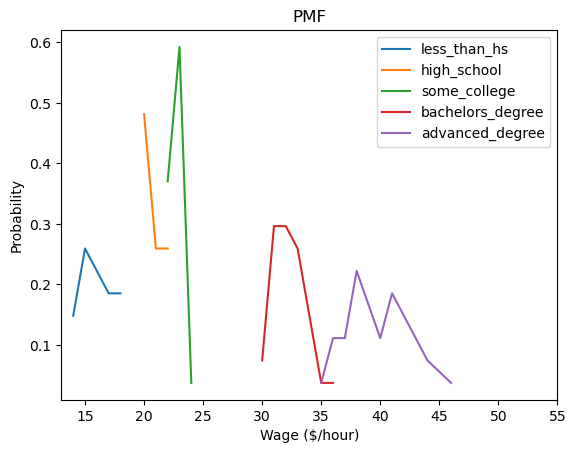

In [110]:
make_pmfs(before_2k)

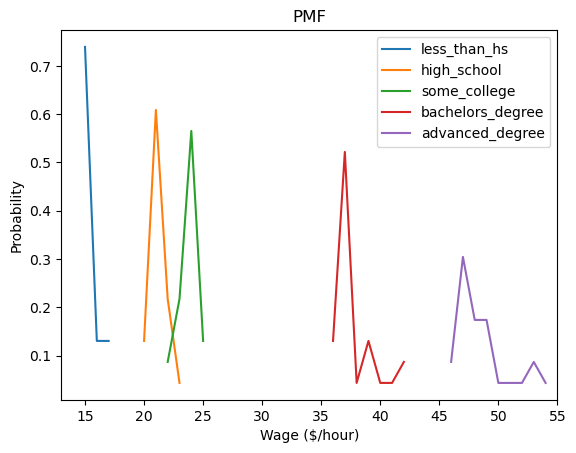

In [111]:
make_pmfs(after_2k)

In [88]:
# make it such that every column has the same name for both the men and women data frames
men.columns = [col[4:] for col in men.columns]
women.columns = [col[6:] for col in women.columns]

In [92]:
# simply subtract the two data frames to get the wage gap for each year and education level
gap = men - women

In [107]:
# this function generates a line chart for each of the columns in the given data frame
def make_line_chart(df):
    for col in df.columns:
        plt.plot(years, df[col], label=col)

    plt.xlabel('Year')
    plt.ylabel('Wage Gap (\$/hour)')
    plt.title('Wage Gap Over Time')
    plt.legend()
    plt.show()

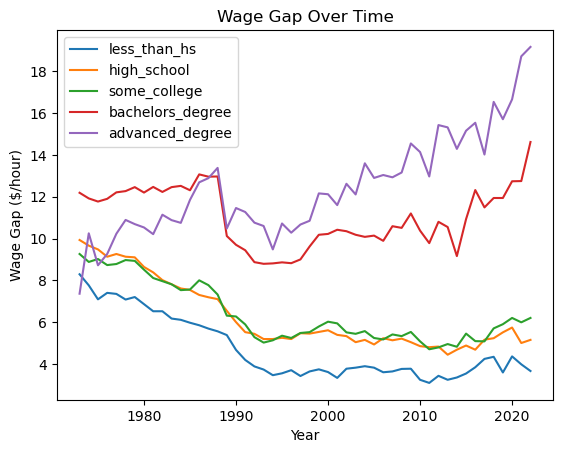

In [108]:
make_line_chart(gap)

In [105]:
# this function generates the cdf for each of the columns in the data frame and plots them together
def make_cdf(df):
    fig, ax = plt.subplots()

    for col in df.columns:
        ecdf = ECDF(df[col])
        ax.plot(ecdf.x, ecdf.y, label=col)

    ax.set_xlabel('Wage Gap (\$/hour)')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title('CDF of the Wage Gap')
    ax.legend()
    plt.show()

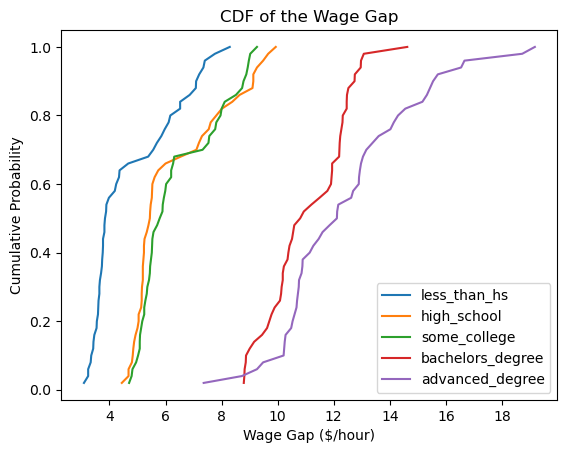

In [106]:
make_cdf(gap)

In [165]:
# this function takes in a data frame, flattens it into a single array, generates a sample log-normal
# distribution, and then plots the distribution over the given data. 
def make_log_norm(df):
    # flatten all of the wage gap data into one array, then get the parameters for the 
    # log-normal distribution
    wage_data = df.values.flatten()
    shape, loc, scale = lognorm.fit(wage_data)
    # get the range of the distribution
    x = np.linspace(min(wage_data), max(wage_data), 1000)
    # get the pdf of the lognormal distribution fitted to the data set
    pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)
    # plot the histogram of the wage gap data, with the log-normal distribution overlayed
    plt.hist(wage_data, bins=30, density=True, alpha=0.2, color='blue', label='Wage Gap Data')
    plt.plot(x, pdf, 'r-', lw=1, label='Log-Normal Distribution')
    plt.xlabel('Wage Gap (\$/hour)')
    plt.ylabel('Probability Density')
    plt.title('Log-Normal Distribution Fit to Wage Gap Data')
    plt.legend()
    plt.show()
    
    ks_statistic, p_value = kstest(wage_data, 'lognorm', args=(shape, loc, scale))
    print(f"Kolmogorov-Smirnov test statistic: {ks_statistic}")
    print(f"P-value: {p_value}")

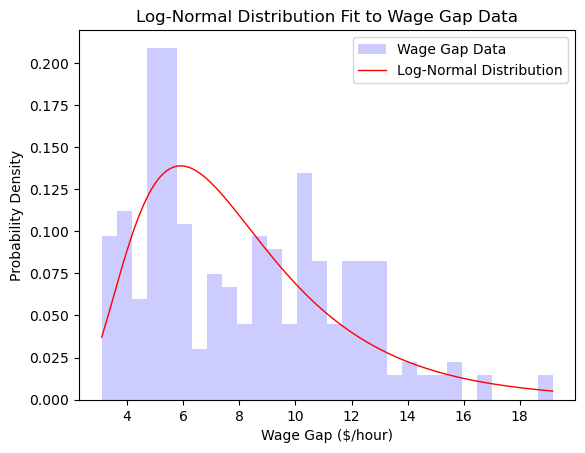

Kolmogorov-Smirnov test statistic: 0.10051534067012036
P-value: 0.011883550359003724


In [166]:
make_log_norm(gap)

In [129]:
# this function generates a scatter plot of the values in one dataframe vs the other data
# frame given that both have the same column names. It also generates the correlation and
# covariance
def make_scatter_plots(df1, df2):   
    # generate a scatter plot over each column
    for col in df1.columns:
        plt.scatter(df1[col], df2[col], alpha=0.5)
        plt.title(f'Scatter Plot of {col} (Men vs Women)')
        plt.xlabel('Men')
        plt.ylabel('Women')
        plt.grid(True)
        plt.show()
        # get the correlation coefficient
        correlation_coefficient = np.corrcoef(df1[col], df2[col])[0, 1]
        print(f"Pearson's correlation coefficient for {col}: {correlation_coefficient}")
        # get the covariance
        covariance = np.cov(df1[col], df2[col])[0, 1]
        print(f"Covariance for {col}: {covariance}\n")

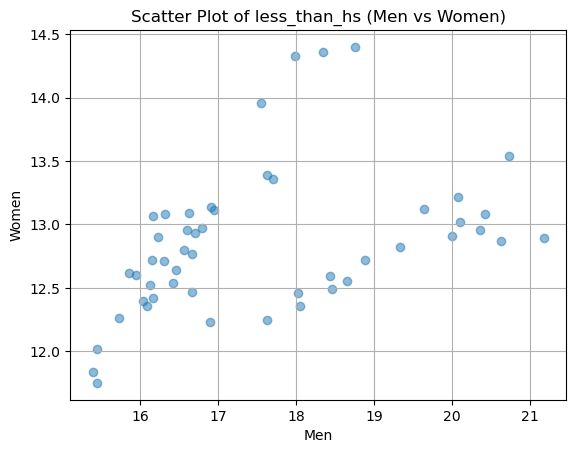

Pearson's correlation coefficient for less_than_hs: 0.40936709147072853
Covariance for less_than_hs: 0.3794027755102042



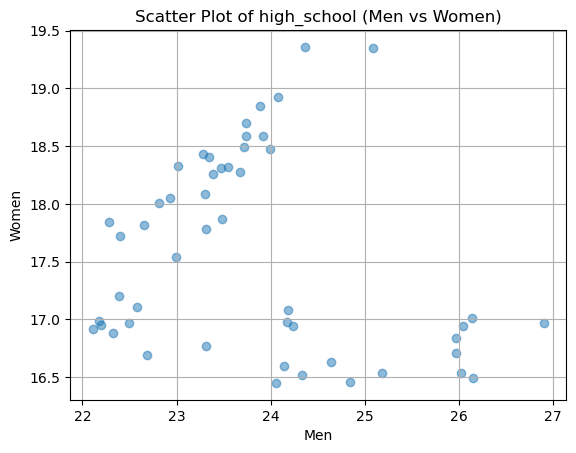

Pearson's correlation coefficient for high_school: -0.22108317658680293
Covariance for high_school: -0.23151036734693842



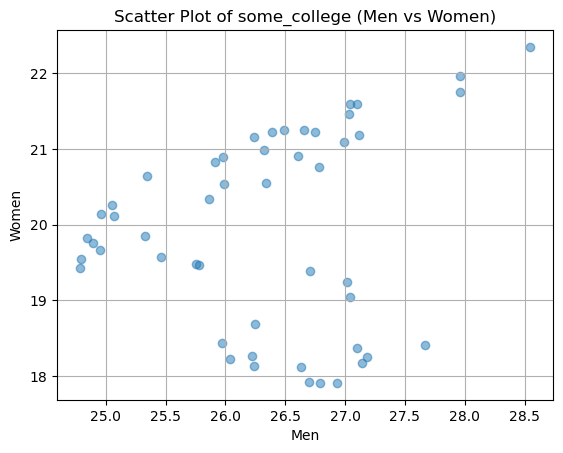

Pearson's correlation coefficient for some_college: 0.17219247888114797
Covariance for some_college: 0.19758555102040834



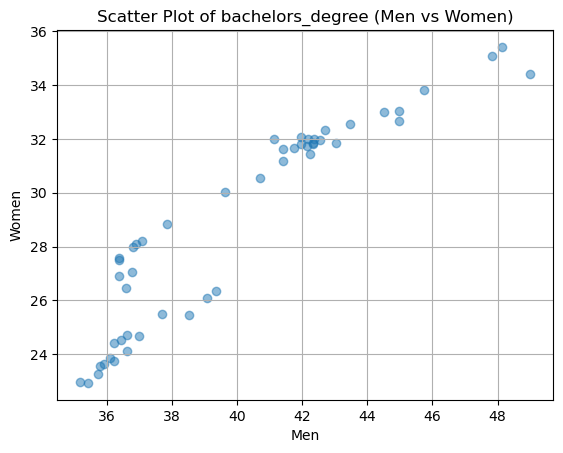

Pearson's correlation coefficient for bachelors_degree: 0.9268341535241581
Covariance for bachelors_degree: 13.017736979591835



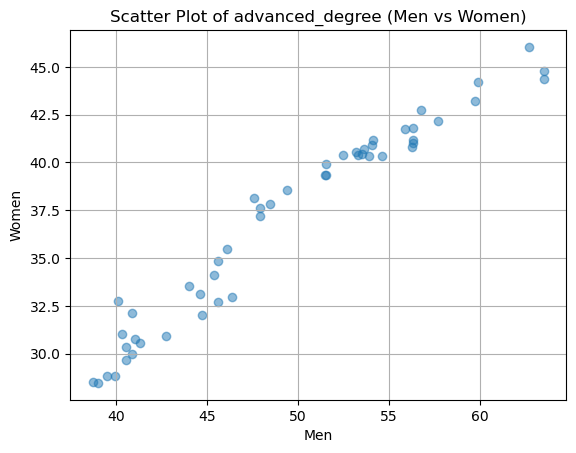

Pearson's correlation coefficient for advanced_degree: 0.9740439154323426
Covariance for advanced_degree: 36.14953771428571



In [130]:
make_scatter_plots(men, women)

In [145]:
# test the hypothesis that the df values have significant changes by 
# using Kendall's Tau-B
def test_hypothesis(df):
    for col in df.columns:
        tau, p_value = kendalltau(years, df[col])

        print(f"*** Hypothesis Test for {col} ***")
        print("---")
        print(f"Kendall's tau-b: {tau}")
        print(f"P-value: {p_value}")
        print("---")


In [149]:
test_hypothesis(gap)

*** Hypothesis Test for less_than_hs ***
---
Kendall's tau-b: -0.5629086845967293
P-value: 8.224558841832918e-09
---
*** Hypothesis Test for high_school ***
---
Kendall's tau-b: -0.7247458917172676
P-value: 1.2388367167678222e-13
---
*** Hypothesis Test for some_college ***
---
Kendall's tau-b: -0.5482027973358568
P-value: 1.9860464050071154e-08
---
*** Hypothesis Test for bachelors_degree ***
---
Kendall's tau-b: 0.017966518443500928
P-value: 0.8539873239818369
---
*** Hypothesis Test for advanced_degree ***
---
Kendall's tau-b: 0.7142857142857143
P-value: 2.493596474326011e-13
---


In [162]:
# this function takes in a data frame and runs a linear regression function with time as the predictor
# and each column as the outcome variable. It then fits the regression line to the scatter plot
# of each wage value by year. 
def make_linear_regression(df):
    # iterate over each column, giving the regression data, line and scatter plot
    for col in df.columns:
        # get the linear model and generate the results of the fit
        model = smf.ols(formula=f'{col} ~ years', data=df)
        results = model.fit()
        # print a summary of the results
        print(results.summary())
        # now plot the given scatter plot and regression line
        plt.scatter(years, df[col], alpha=0.5, color="green", label='Wage Data')
        plt.plot(years, results.predict(df), color='red', label='Regression Line')
        plt.xlabel('Year')
        plt.ylabel('Wage Gap (\$/hour)')
        plt.title(f'Linear Regression for {col}')
        plt.legend()
        plt.grid(True)
        plt.show()


                            OLS Regression Results                            
Dep. Variable:           less_than_hs   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     105.1
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           1.11e-13
Time:                        11:58:58   Log-Likelihood:                -61.668
No. Observations:                  50   AIC:                             127.3
Df Residuals:                      48   BIC:                             131.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    174.8509     16.596     10.536      0.0

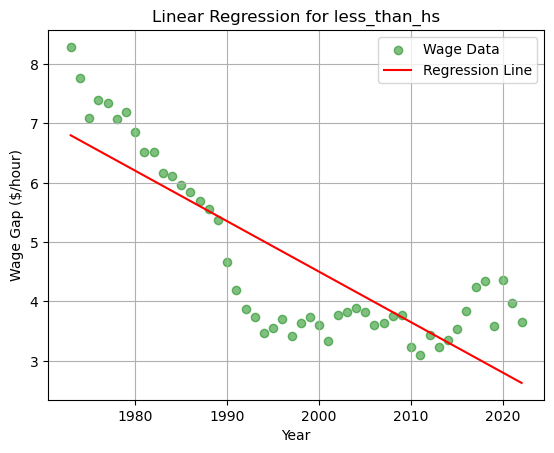

                            OLS Regression Results                            
Dep. Variable:            high_school   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     142.1
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           5.92e-16
Time:                        11:58:58   Log-Likelihood:                -60.818
No. Observations:                  50   AIC:                             125.6
Df Residuals:                      48   BIC:                             129.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    200.7614     16.316     12.305      0.0

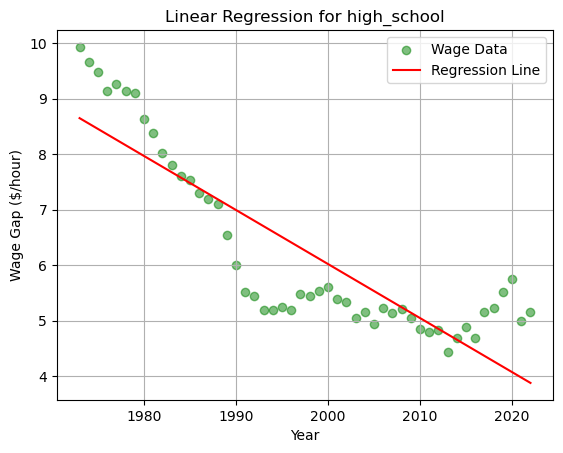

                            OLS Regression Results                            
Dep. Variable:           some_college   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     92.04
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           9.67e-13
Time:                        11:58:58   Log-Likelihood:                -61.548
No. Observations:                  50   AIC:                             127.1
Df Residuals:                      48   BIC:                             130.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    165.2170     16.556      9.979      0.0

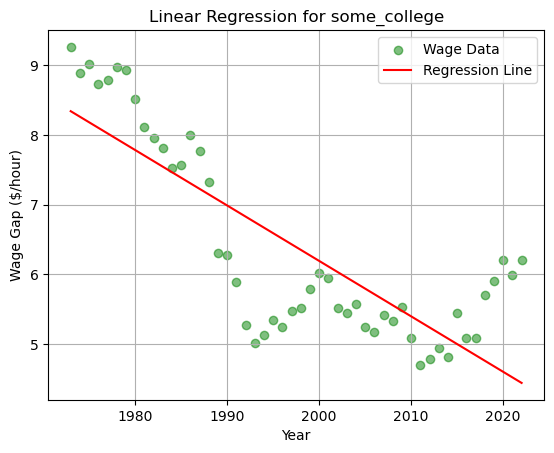

                            OLS Regression Results                            
Dep. Variable:       bachelors_degree   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.029
Date:                Fri, 01 Mar 2024   Prob (F-statistic):              0.315
Time:                        11:58:58   Log-Likelihood:                -87.930
No. Observations:                  50   AIC:                             179.9
Df Residuals:                      48   BIC:                             183.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.5306     28.061      1.409      0.1

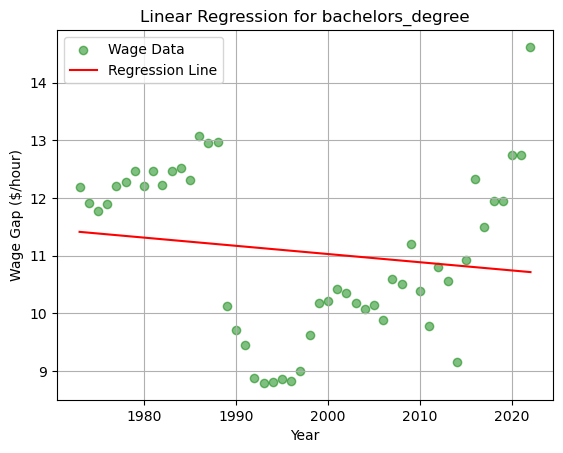

                            OLS Regression Results                            
Dep. Variable:        advanced_degree   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     141.1
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           6.70e-16
Time:                        11:58:58   Log-Likelihood:                -81.286
No. Observations:                  50   AIC:                             166.6
Df Residuals:                      48   BIC:                             170.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -279.4313     24.569    -11.373      0.0

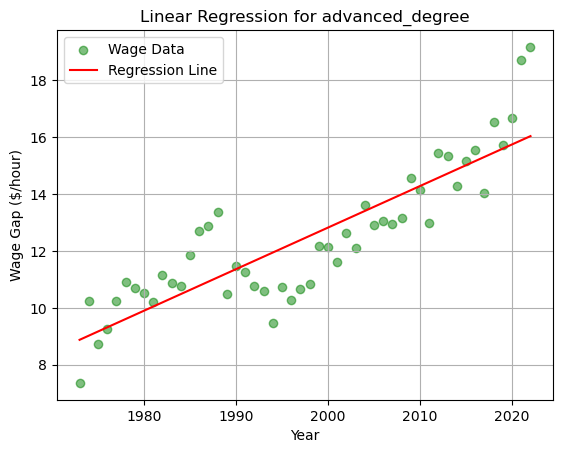

In [163]:
make_linear_regression(gap)